### 1) loading the dataset

In [1]:
# convention : all new inputs parameters for the notebbok through papermil,
# that are progressivelt added have a default value, equal to the one tha would be used in
# order obtain the same results of scripts

# two types of inputs: 
# inputs that influences the training (e.g hyper-paramteres, dataset set and splitting)
# inputs that controls state of training (reset it or load from)

batch_size= 16
d_model = 32
early_stopping_activated = False
half_period_cycle = 5
early_stop_thresh = 3*half_period_cycle
nb_epochs = 300


path_dataset = "../../data/french_english_dataset/fra.txt"
limit_length= 128
use_splitting = False
path_language_info = "../../models/language_info.pth"
path_dataset_splitting = "../../dataset_splitting"

optimizer_option = "AdamW"
base_lr = 0.00001
max_lr = 0.001
momentum=0.9

load_from_backup = True
restore_from_backup = tuple(["model_params","scheduler","optimizer","losses","metrics"])



In [2]:
from dataclasses import dataclass

# by simple hyper
simple_hyper_parameters = dict(
    batch_size= batch_size,
    d_model = d_model,
    early_stopping_activated = early_stopping_activated,
    half_period_cycle = half_period_cycle,
    early_stop_thresh = early_stop_thresh,
    nb_epochs = nb_epochs)

dataset_control = dict(
path_dataset = path_dataset,
path_language_info = path_language_info,
limit_length= limit_length,
use_splitting = use_splitting
)


optimization_control = dict(
optimizer_option = optimizer_option,
base_lr = base_lr,
max_lr = max_lr,
momentum=momentum
)

state_train_control = dict(
load_from_backup = load_from_backup,
restore_from_backup = restore_from_backup
)


@dataclass
class NotebookRun:
    simple_hyper_parameters : dict
    optimization_control : dict
    dataset_control : dict
    state_train_control : dict
    
    def __hash__(self):
        tmp = tuple((
            tuple(self.simple_hyper_parameters.items()),
            tuple(self.optimization_control.items()),
            tuple(self.dataset_control.items()),
            tuple(self.state_train_control.items())         
        ))
        hash_value = hash(tmp)
        return hash_value
    
notebook_run = NotebookRun(simple_hyper_parameters,optimization_control,dataset_control,state_train_control)

In [3]:
from translation_machine import dataset_mod,sentence_mod

import numpy as np
import torch

language_info = torch.load(path_language_info)

vocab_french = language_info["french"]["vocab"]
vocab_english = language_info["english"]["vocab"]

max_length_french = language_info["french"]["max_sentence_train_val"]
max_length_english = language_info["english"]["max_sentence_train_val"]


whole_dataset = dataset_mod.DatasetFromTxt(path_dataset)

idxs_whole = np.arange(limit_length)
dataset = torch.utils.data.Subset(whole_dataset,idxs_whole)

In [4]:
dataset = list(dataset_mod.SentenceDataSet(dataset,sentence_type_src=sentence_mod.EnglishSentence,sentence_type_dst=sentence_mod.FrenchSentence))
len(dataset)

128

In [5]:
# Remark : the responsability to split the dataset is done outside of this notebook
from pathlib import Path

if use_splitting:
    path_idxs_train = str(Path(path_dataset_splitting).joinpath(idxs_train))
    path_idxs_val = str(Path(path_dataset_splitting).joinpath(idxs_val))
    path_idxs_test = str(Path(path_dataset_splitting).joinpath(idxs_test))

    idxs_train = np.load(path_idxs_train)
    idxs_val = np.load(path_idxs_val)
    idxs_test = np.load(path_idxs_test)

    idxs_train,idxs_val,idxs_test = [[idx for idx in idxs if idx<len(whole_dataset)] for idxs in [idxs_train,idxs_val,idxs_test]]
    idxs_train = set(idxs_whole).intersection(set(idxs_train))
    idxs_val = set(idxs_whole).intersection(set(idxs_val))
    idxs_test = set(idxs_whole).intersection(set(idxs_test))
    
else:
    idxs_train = idxs_whole
    idxs_val = idxs_whole
    idxs_test = idxs_whole

train_dataset = torch.utils.data.Subset(dataset,idxs_train)
val_dataset = torch.utils.data.Subset(dataset,idxs_val)
test_dataset = torch.utils.data.Subset(dataset,idxs_test)

### 2) creation the vocabulary

In [6]:
from translation_machine import collate_fn_mod

import torch
from torch.utils.data import DataLoader
import numpy as np

collate_fn = collate_fn_mod.get_collate_fn(max_length_english,max_length_french)


train_data_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,collate_fn=collate_fn)
val_data_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True,collate_fn=collate_fn)

In [7]:
len(vocab_french.vocab.itos_),len(vocab_english.vocab.itos_)

(5407, 4076)

In [8]:
from translation_machine.models import transformer_mod



model_inputs = {
    "d_model":d_model,
    "vocab_src":sentence_mod.EnglishSentence.vocab,
    "vocab_tgt":sentence_mod.FrenchSentence.vocab,
}

model = transformer_mod.TransformerForSeq2Seq(**model_inputs)


In [9]:
from torch import optim
from translation_machine import model_trainer

from torch import nn
baseline_loss = nn.CrossEntropyLoss(reduction="sum")


if optimizer_option == "AdamW":
    optimizer = torch.optim.NAdam(model.parameters(), lr=base_lr)
elif optimizer_option == "SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr=base_lr, momentum=momentum)
else:
    raise ValueError
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,step_size_up=half_period_cycle , base_lr=base_lr, max_lr=max_lr,cycle_momentum=False)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,step_size_up=half_period_cycle , base_lr=base_lr, max_lr=max_lr)
model_trainer = model_trainer.ModelTrainer(model,optimizer,scheduler,train_data_loader,val_data_loader,baseline_loss)


In [31]:
((10)**(-7))*(gamma**400)

3.981071705535124e-06

In [35]:
import time

start = time.time()
min_lr_search = 10**(-7)
max_lr_search = 1.0
size_experiments_step = 2000
cycle_schedule = 5

gamma = np.exp(np.log(max_lr_search/min_lr_search)/(size_experiments_step/cycle_schedule))
optimizer = torch.optim.NAdam(model.parameters(), lr=min_lr_search)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=gamma)

cyclic_shuffled_train_data_loader = (el  for _ in range(size_experiments_step//len(train_data_loader)) for el in train_data_loader)

indexed_cyclic_shuffled_train_data_loader = enumerate(cyclic_shuffled_train_data_loader)
losses_lr_finder = []
lrs = []
for idx,batch in indexed_cyclic_shuffled_train_data_loader:
    loss,nb_words = model_trainer.train_on_batch(batch)
    loss = float(loss)
    if idx%cycle_schedule==0:
        print(idx,scheduler.get_last_lr())
        scheduler.step()
    print(loss/nb_words,scheduler.get_last_lr())
    losses_lr_finder.append(loss/nb_words)
    lrs.append(scheduler.get_last_lr())
    
stop = time.time()
print(stop-start)

0 [1e-07]
6.697950526646205 [1.0411181076233395e-07]
6.420473160282258 [1.0411181076233395e-07]
6.692581391670335 [1.0411181076233395e-07]
6.468239784240723 [1.0411181076233395e-07]
6.532458026592548 [1.0411181076233395e-07]
5 [1.0411181076233395e-07]
6.46437406539917 [1.0839269140212036e-07]
6.50412362905649 [1.0839269140212036e-07]
6.511082504734849 [1.0839269140212036e-07]
6.30675303141276 [1.0839269140212036e-07]
6.53557825088501 [1.0839269140212036e-07]
10 [1.0839269140212036e-07]
6.556682702266809 [1.1284959375277617e-07]
6.556656567018424 [1.1284959375277617e-07]
6.688894171463816 [1.1284959375277617e-07]
6.324080368568158 [1.1284959375277617e-07]
6.6253653263700185 [1.1284959375277617e-07]
15 [1.1284959375277617e-07]
6.663862086054104 [1.1748975549395297e-07]
6.560739135742187 [1.1748975549395297e-07]
6.662484431612318 [1.1748975549395297e-07]
6.579515245225695 [1.1748975549395297e-07]
6.444866846478175 [1.1748975549395297e-07]
20 [1.1748975549395297e-07]
6.353360083795363 [1.2

6.372521072137551 [4.0973210981354246e-07]
6.557540068755278 [4.0973210981354246e-07]
6.4962950675718245 [4.0973210981354246e-07]
6.020709228515625 [4.0973210981354246e-07]
175 [4.0973210981354246e-07]
6.458700469045928 [4.265795188015937e-07]
6.411154926687047 [4.265795188015937e-07]
6.503007087154665 [4.265795188015937e-07]
6.284317508820565 [4.265795188015937e-07]
6.464166550409226 [4.265795188015937e-07]
180 [4.265795188015937e-07]
6.326535224914551 [4.4411966136559003e-07]
6.434638023376465 [4.4411966136559003e-07]
6.581379045758928 [4.4411966136559003e-07]
6.414123072768703 [4.4411966136559003e-07]
6.395969801682693 [4.4411966136559003e-07]
185 [4.4411966136559003e-07]
6.35591786702474 [4.6238102139926146e-07]
6.243979618467134 [4.6238102139926146e-07]
6.467057620777803 [4.6238102139926146e-07]
6.469948546527183 [4.6238102139926146e-07]
6.527642822265625 [4.6238102139926146e-07]
190 [4.6238102139926146e-07]
6.477500794425843 [4.81393254000146e-07]
6.440856061662946 [4.81393254000

6.360877093146829 [1.6125010273377487e-06]
6.517863880504262 [1.6125010273377487e-06]
6.139548608812235 [1.6125010273377487e-06]
345 [1.6125010273377487e-06]
6.440592751574161 [1.6788040181225679e-06]
6.313779769405242 [1.6788040181225679e-06]
6.393867492675781 [1.6788040181225679e-06]
6.264047622680664 [1.6788040181225679e-06]
6.4121062790138135 [1.6788040181225679e-06]
350 [1.6788040181225679e-06]
6.299294087424207 [1.7478332624182265e-06]
6.321699911089086 [1.7478332624182265e-06]
6.413300850022007 [1.7478332624182265e-06]
6.3610155659337195 [1.7478332624182265e-06]
6.009400992557921 [1.7478332624182265e-06]
355 [1.7478332624182265e-06]
6.476225087340449 [1.819700858609992e-06]
6.285768423507463 [1.819700858609992e-06]
6.293761282256155 [1.819700858609992e-06]
6.362794421968006 [1.819700858609992e-06]
6.439423049705616 [1.819700858609992e-06]
360 [1.819700858609992e-06]
6.237460974491004 [1.8945235143566009e-06]
6.335638523101807 [1.8945235143566009e-06]
6.525283168738996 [1.8945235

6.1247711181640625 [6.345999009812911e-06]
6.347894841974432 [6.345999009812911e-06]
515 [6.345999009812911e-06]
6.119060516357422 [6.606934480076005e-06]
6.338820563422309 [6.606934480076005e-06]
6.072157234981142 [6.606934480076005e-06]
6.184298940805289 [6.606934480076005e-06]
6.281185374540441 [6.606934480076005e-06]
520 [6.606934480076005e-06]
6.130261395428632 [6.878599123088124e-06]
6.189125598316461 [6.878599123088124e-06]
6.279378255208333 [6.878599123088124e-06]
6.416970729827881 [6.878599123088124e-06]
6.1519419352213545 [6.878599123088124e-06]
525 [6.878599123088124e-06]
6.354765479244403 [7.16143410212907e-06]
6.1529039980760265 [7.16143410212907e-06]
6.215115906762295 [7.16143410212907e-06]
6.336971507352941 [7.16143410212907e-06]
6.112548828125 [7.16143410212907e-06]
530 [7.16143410212907e-06]
6.29768212161847 [7.455898720277867e-06]
6.087138905244715 [7.455898720277867e-06]
6.19843222878196 [7.455898720277867e-06]
6.422046436982996 [7.455898720277867e-06]
6.352375454372

6.1728955437155335 [2.4974683891541656e-05]
6.180143468520221 [2.4974683891541656e-05]
685 [2.4974683891541656e-05]
6.140495300292969 [2.600159563165295e-05]
6.261020714128521 [2.600159563165295e-05]
6.225849036014441 [2.600159563165295e-05]
6.023102306928791 [2.600159563165295e-05]
6.356642711011669 [2.600159563165295e-05]
690 [2.600159563165295e-05]
5.740604795258621 [2.7070732039213813e-05]
6.155477350408381 [2.7070732039213813e-05]
6.171422958374023 [2.7070732039213813e-05]
6.219150652204241 [2.7070732039213813e-05]
6.222537321202895 [2.7070732039213813e-05]
695 [2.7070732039213813e-05]
6.098832927766393 [2.8183829312644793e-05]
6.154606745793269 [2.8183829312644793e-05]
6.16288039263557 [2.8183829312644793e-05]
6.2543275747726215 [2.8183829312644793e-05]
6.206709740867077 [2.8183829312644793e-05]
700 [2.8183829312644793e-05]
6.256023522579309 [2.9342695039559955e-05]
5.990361213684082 [2.9342695039559955e-05]
5.960330708821615 [2.9342695039559955e-05]
6.079335992986506 [2.93426950

6.136695168235085 [0.00010232929922807654]
6.054833730061849 [0.00010232929922807654]
6.005066856971154 [0.00010232929922807654]
5.8815607870778726 [0.00010232929922807654]
860 [0.00010232929922807654]
5.982931283804087 [0.00010653688636675751]
6.184615405637826 [0.00010653688636675751]
5.9384859146610385 [0.00010653688636675751]
5.995542638442096 [0.00010653688636675751]
5.920579213944692 [0.00010653688636675751]
865 [0.00010653688636675751]
5.958656964983259 [0.00011091748152624135]
6.103853630297111 [0.00011091748152624135]
6.138343924906716 [0.00011091748152624135]
5.901808399265096 [0.00011091748152624135]
6.109226002412684 [0.00011091748152624135]
870 [0.00011091748152624135]
5.976308969350962 [0.00011547819846894712]
6.079393027485281 [0.00011547819846894712]
6.115988204728311 [0.00011547819846894712]
5.800875663757324 [0.00011547819846894712]
6.037361266121032 [0.00011547819846894712]
875 [0.00011547819846894712]
6.101547468954058 [0.00012022644346174265]
6.120735289558532 [0.0

6.061531398607337 [0.00040271703432546426]
5.898406043419471 [0.00040271703432546426]
5.993930982506794 [0.00040271703432546426]
5.649924968851024 [0.00040271703432546426]
1030 [0.00040271703432546426]
6.040050833565848 [0.00041927599668461086]
5.8964812790138135 [0.00041927599668461086]
5.955594501798115 [0.00041927599668461086]
5.946977302209655 [0.00041927599668461086]
5.8051024406186995 [0.00041927599668461086]
1035 [0.00041927599668461086]
5.949756145477295 [0.00043651583224017164]
5.98491472516741 [0.00043651583224017164]
5.825750350952148 [0.00043651583224017164]
5.932459662942326 [0.00043651583224017164]
5.983908832937047 [0.00043651583224017164]
1040 [0.00043651583224017164]
5.896552085876465 [0.00045446453720951463]
5.713952128092448 [0.00045446453720951463]
6.039941062389965 [0.00045446453720951463]
5.73133308656754 [0.00045446453720951463]
5.955930679563492 [0.00045446453720951463]
1045 [0.00045446453720951463]
5.961427992668705 [0.00047315125896148664]
6.121014811197917 [0

5.9919866305678635 [0.0015848931924611366]
5.858916780841884 [0.0015848931924611366]
1200 [0.0015848931924611366]
5.958623316380884 [0.0016500610013202518]
5.980166227921195 [0.0016500610013202518]
5.869355574898098 [0.0016500610013202518]
5.629726954868862 [0.0016500610013202518]
5.795943751479641 [0.0016500610013202518]
1205 [0.0016500610013202518]
5.7609710693359375 [0.0017179083871576135]
5.8565166842552925 [0.0017179083871576135]
5.7117162068684895 [0.0017179083871576135]
5.943095313178168 [0.0017179083871576135]
5.641880844578599 [0.0017179083871576135]
1210 [0.0017179083871576135]
5.674419403076172 [0.0017885455291077978]
5.965278856682055 [0.0017885455291077978]
5.776216568485383 [0.0017885455291077978]
6.05483161078559 [0.0017885455291077978]
5.853575206938244 [0.0017885455291077978]
1215 [0.0017885455291077978]
5.6486132221837195 [0.001862087136662895]
5.839991327541978 [0.001862087136662895]
5.814211261806204 [0.001862087136662895]
5.9305428767549815 [0.001862087136662895]
5

5.785429113051471 [0.006493816315762224]
5.496823068392479 [0.006493816315762224]
5.941353157775043 [0.006493816315762224]
5.758527613397854 [0.006493816315762224]
1375 [0.006493816315762224]
5.737884521484375 [0.006760829753919934]
5.7639075646033655 [0.006760829753919934]
5.728566196986607 [0.006760829753919934]
5.833463264234139 [0.006760829753919934]
5.829289678317397 [0.006760829753919934]
1380 [0.006760829753919934]
5.643517872643849 [0.0070388222793646895]
5.541156102740575 [0.0070388222793646895]
5.782345241970486 [0.0070388222793646895]
5.68040291922433 [0.0070388222793646895]
5.692317222481344 [0.0070388222793646895]
1385 [0.0070388222793646895]
5.658555507659912 [0.007328245331389167]
5.615260731090199 [0.007328245331389167]
5.851797739664714 [0.007328245331389167]
5.594041560246394 [0.007328245331389167]
5.943619223201976 [0.007328245331389167]
1390 [0.007328245331389167]
5.946126302083333 [0.007629568911615463]
5.539847163830773 [0.007629568911615463]
5.715021105780118 [0.

5.487462278272285 [0.026607250597988606]
5.378241867315574 [0.026607250597988606]
1550 [0.026607250597988606]
5.819446048221073 [0.027701290391637868]
5.643874168395996 [0.027701290391637868]
5.675856236049107 [0.027701290391637868]
5.627598033231847 [0.027701290391637868]
5.463785462460275 [0.027701290391637868]
1555 [0.027701290391637868]
5.523125036438899 [0.028840315031266616]
5.568780422210693 [0.028840315031266616]
5.587618741122159 [0.028840315031266616]
5.739174786735983 [0.028840315031266616]
5.664493502103365 [0.028840315031266616]
1560 [0.028840315031266616]
5.480568537636409 [0.030026174208613254]
5.61285400390625 [0.030026174208613254]
5.498180613798254 [0.030026174208613254]
5.760836976947206 [0.030026174208613254]
5.6438714890252974 [0.030026174208613254]
1565 [0.030026174208613254]
5.500997876364087 [0.031260793671240156]
5.762304517957899 [0.031260793671240156]
5.691914413914536 [0.031260793671240156]
5.456497654770359 [0.031260793671240156]
5.627537318638393 [0.031260

5.627307037809002 [0.11350108156723393]
5.622865096382473 [0.11350108156723393]
1730 [0.11350108156723393]
5.396565451550839 [0.1181680312544809]
5.608795166015625 [0.1181680312544809]
5.398037380642361 [0.1181680312544809]
5.430953296262826 [0.1181680312544809]
5.57632821890024 [0.1181680312544809]
1735 [0.1181680312544809]
5.4834068052230345 [0.1230268770812408]
5.38726806640625 [0.1230268770812408]
5.474954927884616 [0.1230268770812408]
5.462416463823461 [0.1230268770812408]
5.672497373638731 [0.1230268770812408]
1740 [0.1230268770812408]
5.498771778051404 [0.12808550945363062]
5.537737759676847 [0.12808550945363062]
5.424251433341734 [0.12808550945363062]
5.566147071727808 [0.12808550945363062]
5.579066421046401 [0.12808550945363062]
1745 [0.12808550945363062]
5.2995698990360385 [0.1333521432163353]
5.572877343021222 [0.1333521432163353]
5.449408897986779 [0.1333521432163353]
5.476817908653846 [0.1333521432163353]
5.2311859130859375 [0.1333521432163353]
1750 [0.1333521432163353]
5.

5.463911056518555 [0.5040806191026815]
5.478777336351799 [0.5040806191026815]
5.428240226976799 [0.5040806191026815]
5.432329582445549 [0.5040806191026815]
1915 [0.5040806191026815]
5.366245330326141 [0.5248074602497852]
5.341425653713853 [0.5248074602497852]
5.416362459697421 [0.5248074602497852]
5.20314884185791 [0.5248074602497852]
5.644266340467665 [0.5248074602497852]
1920 [0.5248074602497852]
5.316074494392641 [0.5463865498818674]
5.481842041015625 [0.5463865498818674]
5.089735921223959 [0.5463865498818674]
5.50127694266183 [0.5463865498818674]
5.320939540863037 [0.5463865498818674]
1925 [0.5463865498818674]
5.6019265916612415 [0.5688529308438552]
5.287027327740779 [0.5688529308438552]
5.498201706830193 [0.5688529308438552]
5.472726770349451 [0.5688529308438552]
5.097191874186198 [0.5688529308438552]
1930 [0.5688529308438552]
5.310842037200928 [0.592243086876145]
5.551572495612545 [0.592243086876145]
5.386903263972356 [0.592243086876145]
5.741016163545496 [0.592243086876145]
5.53

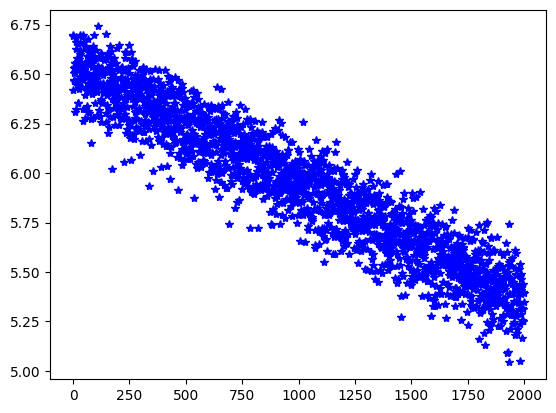

In [36]:
import matplotlib.pyplot as plt
plt.plot(losses_lr_finder,"b*")

In [ ]:
from itertools import cycle,islice
cycle(train_data_loader)
#for idx,el in islice(enumerate(cycle(train_data_loader)),20):
for idx,el in enumerate(cyclic_shuffled_train_data_loader):
    pass
    #print(idx//limit_length,el[0][0][:10])

In [ ]:
from torch_lr_finder import LRFinder
import pdb
optimizer = torch.optim.NAdam(model.parameters(), lr=base_lr)
lr_finder = LRFinder(model, optimizer, baseline_loss, device="cuda")
pdb.runcall(lr_finder.range_test,train_data_loader, end_lr=10, num_iter=100)

In [ ]:
for el in train_data_loader:
    break

In [ ]:
help(model_trainer.train_on_batch)

In [ ]:
from tqdm import tqdm
model.train()
losses = {"train":[],"val":[]}
metrics = {"train":[],"val":[]}


In [ ]:
from pathlib import Path
import torch
path_model_and_dependencies = "../../models/sequence_translator_transformer_over_fitted_adamw.pth"

if load_from_backup and Path(path_model_and_dependencies).exists():
    back_up = torch.load(path_model_and_dependencies)
    for el1,el2 in zip([model,scheduler,optimizer,scheduler,losses,metrics],
                      ["model_params","scheduler","optimizer","losses","metrics"]):
        if el2 in restore_from_backup:
            if el2 == "losses":
                losses = back_up[el2]
            elif el2 == "metrics":
                metrics = back_up[el2]
            else:
                el1.load_state_dict(back_up[el2])
                
    print("model loaded")

In [ ]:
import matplotlib.pyplot as plt

best_loss_val_mean = np.inf
best_epoch = scheduler.last_epoch

for epoch in tqdm(range(nb_epochs)):
    #import time
    #start = time.time()
    print(f"optimizing for epoch {epoch}")
    print("training_step")
    loss_train,nb_words_per_batch_train,metric_train = model_trainer.train_on_epoch()
    
    print("validation_step")
    loss_val,nb_words_per_batch_val,metric_val = model_trainer.validate_on_epoch()

    loss_train = np.array([float(el) for el in loss_train])
    loss_val = np.array([float(el) for el in loss_val])
    train_weights = 1/sum(nb_words_per_batch_train)
    val_weights = 1/sum(nb_words_per_batch_val)
    
    
        
    losses["train"].append(np.sum(loss_train)/sum(nb_words_per_batch_train))
    losses["val"].append(np.sum(loss_val)/sum(nb_words_per_batch_val))
    metrics["train"].append(metric_train)
    metrics["val"].append(metric_val)
    
    current_loss_val_mean = np.mean(loss_val)
    
    if (current_loss_val_mean < best_loss_val_mean):
        best_epoch = scheduler.last_epoch
        best_loss_val_mean = current_loss_val_mean

        model_training_state = {"model_params":model_trainer.model.state_dict(),
                               "model_inputs":model_inputs,
                              "optimizer":optimizer.state_dict(),
                              "scheduler":scheduler.state_dict(),
                              "losses":losses,
                              "metrics":metrics
                              }
        
        torch.save(state_dict_extended,path_model_and_dependencies)
        print(f"saving for epoch {epoch}")

        plt.plot(losses["train"],"b*")
        plt.plot(losses["val"],"g*")
        plt.title("losses")
        plt.show()        
        #plt.figure()
        #plt.plot(metrics["train"],"b*")
        #plt.plot(metrics["val"],"g*")
        #plt.title("bleu score")
        #plt.show()
    elif epoch - best_epoch > early_stop_thresh  and early_stopping_activated:
        print("Early stopped training at epoch %d" % epoch)
        break  # terminate the training loop
    #stop = time.time()
    #print(stop-start)

    del loss_train,nb_words_per_batch_train,metric_train

    del loss_val,nb_words_per_batch_val,metric_val


In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses["train"],"b*")
plt.plot(losses["val"],"g*")
plt.title("losses")
plt.show()        